# Weather Model for Taxi Availability EDA

In this notebook we will download data via the APIs from NEA, and create a prototype dataset.

The high level overview of our ML solution will be as follows:
- User takes out phone at a point in time
- Types in his destination
- Model calculates probability at that point in time what the availability range of taxis will be at that point in time at his location (nearest weather station)
- Calls Google Maps API to get route and distance
- Calculates base fee and then surge estimate for the route
- Optional: Accounts for tolls along the way

# Preamble

Get the packages ready

In [1]:
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import itertools

# Key Variables

Declare key variables here

In [2]:
query="2019-01-01T20:00:00"

## Define functions

Write the functions to pull data from the APIs

In [3]:
def get_weather_data(query:str):
    '''Returns dictionary of JSON objects for weather data given a datetime string
    Each entry in the dictionary is the JSON response for each of the API Endpoints of
     ["air-temperature","rainfall","relative-humidity"]    
    '''
    data_sets = ["air-temperature","rainfall","relative-humidity"]
    results={}
    for measure in data_sets:
        URL = "https://api.data.gov.sg/v1/environment/"+measure
        params={'date_time':query}
        r=requests.get(URL,params=params)
        results[measure]=r.json()
    return results

def get_taxi_data(query:str):
    '''Returns the coordinates of all taxis via the LTA API endpoint for a given datetime string
    '''
    URL = "https://api.data.gov.sg/v1/transport/taxi-availability"
    params={'date_time':query}
    r=requests.get(URL,params=params)
    return r.json()

# Retrieving Single Timestamp Data

This section deals with downloading the data and creating the dataset

We create `numpy` arrays for the coordinates for each taxi and weather station, calculate the Euclidean Distance from each taxi to the weather station, and then assign that taxi to the nearest weather station.

We then calculate the number of taxis available for each weather station.

In [4]:
weather_data=get_weather_data(query=query)
taxi_data=get_taxi_data(query=query)

In [5]:
taxi_coordinates = taxi_data['features'][0]['geometry']['coordinates']
station_dict = weather_data['rainfall']['metadata']['stations']
station_id = [i['id'] for i in station_dict]
taxi_array = np.array([t[::-1] for t in taxi_coordinates]) # taxi_coordinates are reversed, need to fix
station_array = np.array([[station_dict[i]['location']['latitude'],station_dict[i]['location']['longitude']] for i in range(len(station_dict))])

## Taxi Scatterplot

Here's how the distribution of taxis looks like at the specified timestamp

In [6]:
def plot_taxi_availability(taxi_array:type(np.ndarray),station_array:type(np.ndarray),assignment:type(np.ndarray)=None,query:str=None):
    '''Plots taxis and weather stations on a scatterplot
    '''
    plt.figure(figsize=(10, 6), dpi=100)
    sns.scatterplot(x=station_array[:,0],y=station_array[:,1],s=100,marker='s')

    labels = []
    labels.append('Station')
    if assignment:
        sns.scatterplot(x=taxi_array[:,0],y=taxi_array[:,1],hue=assignment,palette='nipy_spectral',marker='v')
        labels.extend([f"Assigned {i}" for i in np.unique(assignment)])
    else:
        sns.scatterplot(x=taxi_array[:,0],y=taxi_array[:,1],marker='v')
        labels.append('Taxis')    
    plt.legend(labels=labels)
    plt.title(f"Taxi Availability {query}")
    plt.show()

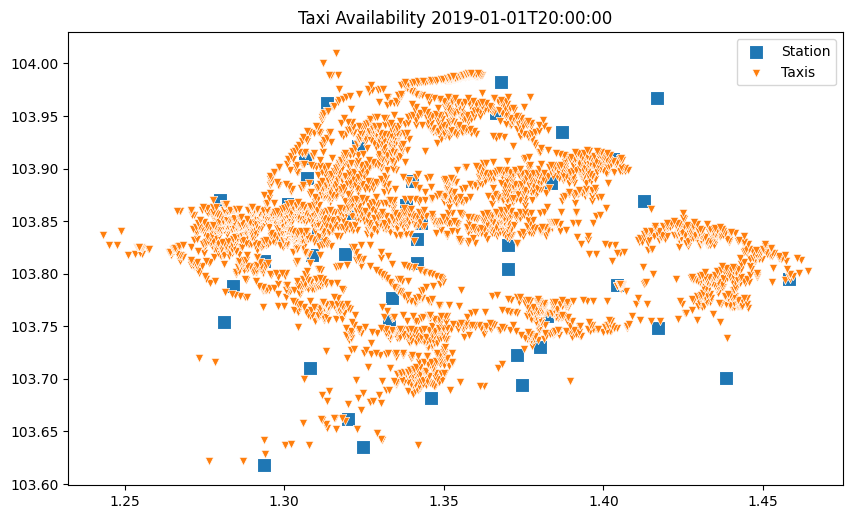

In [7]:
plot_taxi_availability(taxi_array,station_array,query=query)

## Taxi Assignment

Assign each taxi to the nearest weather station by Euclidean Distance

In [8]:
def assign_taxis(taxi_array:type(np.array),station_array:type(np.array)):
    cartesian_prod = itertools.product(taxi_array,station_array) # Cartesian product for taxi and weather station coordinates
    diff = np.array([i[0]-i[1] for i in cartesian_prod]) 
    distance = np.linalg.norm(diff,axis=1)
    distance_matrix = distance.reshape((len(taxi_array),len(station_array),-1)) # Reshape back into distances since the cartesian product only has one dimension
    return [np.argmin(distance_matrix[i]) for i in range(len(taxi_array))]

## Assignment Breakdown by Station

Visualizing the number of taxis assigned to each weather station at the pre-determined timestamp

**TODO: Join with the next section**

In [9]:
assignment = assign_taxis(taxi_array,station_array)
assignment_series = pd.Series(assignment)
assignment_counts = assignment_series.value_counts().sort_index().rename('taxis')
assignment_counts

0     239
1     190
2     253
3     187
4      23
5     194
6      45
7       3
8      97
9      78
10    371
11     34
12     23
13    113
15     19
16     91
17    128
18     54
19     98
20    176
21     47
22    228
23     37
24    210
25    116
27    112
28     80
29    164
30     28
31    198
32     75
33    165
34    128
35     19
36      7
37      7
38    422
40     84
41    183
42      8
43     56
Name: taxis, dtype: int64

Text(0.5, 1.0, 'Taxi availability 2019-01-01T20:00:00')

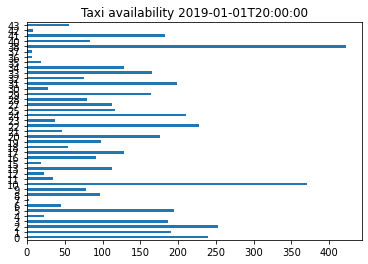

In [10]:
assignment_counts.plot(kind='barh')
plt.title(f"Taxi availability {query}")

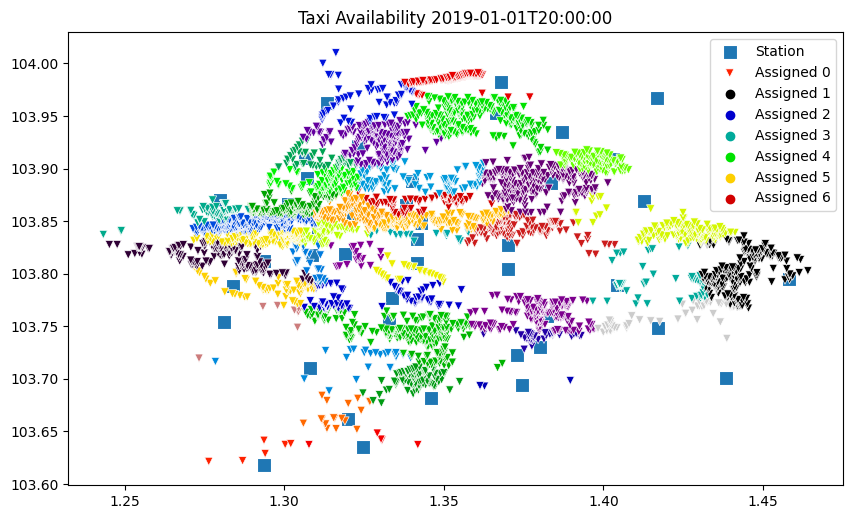

In [11]:
plot_taxi_availability(taxi_array,station_array,assignment=assignment,query=query)

# Weather Data

In this section, we need to create the dataframe for the actual weather data by station. Example of a complete record will look like this:
|device_id|latitide|longitude|air-temperature|rainfall|relative-humidity|taxis|timestamp|
|---|---|---|---|---|---|---|---|
|S109|1.3764|103.8492|29.2|0|75.1|150|2022-04-26T20:00:00|

In [12]:
rainfall_array = np.array([i['value'] for i in weather_data['rainfall']['items'][0]['readings']])
air_temperature_array = np.array([i['value'] for i in weather_data['air-temperature']['items'][0]['readings']])
relative_humidity_array = np.array([i['value'] for i in weather_data['relative-humidity']['items'][0]['readings']])

In [13]:
lat_series = pd.Series(station_array[:,0],name='latitude')
lon_series = pd.Series(station_array[:,1],name='longitude')
rainfall_series = pd.Series(rainfall_array,name='rainfall')
station_id_series = pd.Series(station_id,name='device_id')

In [14]:
df = pd.concat([station_id_series, lat_series,lon_series,rainfall_series,assignment_counts],axis=1)
df['timestamp']=query
df

,device_id,latitude,longitude,rainfall,taxis,timestamp
0,S105,1.45817,103.79525,0,239.0,2019-01-01T20:00:00
1,S77,1.29370,103.81250,0,190.0,2019-01-01T20:00:00
2,S55,1.38370,103.88600,0,253.0,2019-01-01T20:00:00
3,S64,1.38240,103.76030,0,187.0,2019-01-01T20:00:00
4,S90,1.31910,103.81910,0,23.0,2019-01-01T20:00:00
5,S61,1.32300,103.92170,0,194.0,2019-01-01T20:00:00
6,S114,1.38000,103.73000,0,45.0,2019-01-01T20:00:00
7,S11,1.37460,103.69380,0,3.0,2019-01-01T20:00:00
8,S50,1.33370,103.77680,0,97.0,2019-01-01T20:00:00
9,S107,1.31350,103.96250,0,78.0,2019-01-01T20:00:00


# Data Loading

Now that we have the code to pull data at a point in time, we need to build our database over time.

Time stamps at 15 min intervals over 1 full year?

$15min \times 4 \times 24 \times 365 \times N_{weather stations}= 525,600 N_{weather stations}/year$

# Modeling

**REQUIRED: DataFrame with weather data by station and corresponding number of taxis**

Try different time lag for forecasting availability. 1 min, 15 min, 30 min etc.

# Serving Prediction

TODO: Decide on what we are trying to predict